In [229]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
import json

In [230]:
# https://www.kaggle.com/tmdb/tmdb-movie-metadata
#!wget https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv

In [231]:
df = pd.read_csv('tmdb_5000_movies.csv')

In [232]:
df.dropna()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4773,27000,"[{""id"": 35, ""name"": ""Comedy""}]",http://www.miramax.com/movie/clerks/,2292,"[{""id"": 1361, ""name"": ""salesclerk""}, {""id"": 30...",en,Clerks,Convenience and video store clerks Dante and R...,19.748658,"[{""name"": ""Miramax Films"", ""id"": 14}, {""name"":...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1994-09-13,3151130,92.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Just because they serve you doesn't mean they ...,Clerks,7.4,755
4781,22000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",https://www.facebook.com/DrySpellMovie,255266,"[{""id"": 13043, ""name"": ""dating""}, {""id"": 15160...",en,Dry Spell,Sasha tries to get her soon-to-be ex husband K...,0.048948,[],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2013-02-14,0,90.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Getting divorced does funny things to a girl,Dry Spell,6.0,1
4791,13,"[{""id"": 27, ""name"": ""Horror""}]",http://tincanmanthemovie.com/,157185,"[{""id"": 14903, ""name"": ""home invas

In [233]:
df["keywords"][0]

'[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]'

In [234]:
df["overview"]

0       In the 22nd century, a paraplegic Marine is di...
1       Captain Barbossa, long believed to be dead, ha...
2       A cryptic message from Bond’s past sends him o...
3       Following the death of District Attorney Harve...
4       John Carter is a war-weary, former military ca...
                              ...                        
4798    El Mariachi just wants to play his guitar and ...
4799    A newlywed couple's honeymoon is upended by th...
4800    "Signed, Sealed, Delivered" introduces a dedic...
4801    When ambitious New York attorney Sam is sent t...
4802    Ever since the second grade when he first saw ...
Name: overview, Length: 4803, dtype: object

In [235]:
df["tagline"]

0                             Enter the World of Pandora.
1          At the end of the world, the adventure begins.
2                                   A Plan No One Escapes
3                                         The Legend Ends
4                    Lost in our world, found in another.
                              ...                        
4798    He didn't come looking for trouble, but troubl...
4799    A newlywed couple's honeymoon is upended by th...
4800                                                  NaN
4801                             A New Yorker in Shanghai
4802                                                  NaN
Name: tagline, Length: 4803, dtype: object

In [236]:
def keywords_to_string(df):
    wordlist = " ".join([word["name"] for word in json.loads(df["keywords"])])
    return "%s" % (wordlist)
def genres_to_string(df):
    wordlist = " ".join([word["name"] for word in json.loads(df["genres"])])
    return "%s" % (wordlist)
def replaceNaN(df, col):
    df[col] = df[col].replace([np.nan], " ")
    return df[col]

In [237]:
df["strkeywords"] = df.apply(keywords_to_string, axis=1)
df["strgenres"] = df.apply(genres_to_string, axis=1)
df["tagline"] = replaceNaN(df, "tagline")
df["overview"] = replaceNaN(df, "overview")
x = df["title"] + df["strgenres"] + df["strkeywords"] + " " + df["tagline"] + " " + df["overview"]

#print(df.iloc[4401])
#df["overview length"]= df["overview"].str.len() 
#[print(n, z) for n, z in enumerate(df["overview"]) if df["overview length"] < 10]

df["string"] = [z for n, z in enumerate(x)]
tfidf = TfidfVectorizer()#max_features = 2000)
X = tfidf.fit_transform(df["string"])
X

<4803x30408 sparse matrix of type '<class 'numpy.float64'>'
	with 273201 stored elements in Compressed Sparse Row format>

In [238]:
movie2idx = pd.Series(df.index, index=df['title'])
movie2idx

title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

In [239]:
idx = movie2idx['The Notebook']
query = X[idx]
query

<1x30408 sparse matrix of type '<class 'numpy.float64'>'
	with 60 stored elements in Compressed Sparse Row format>

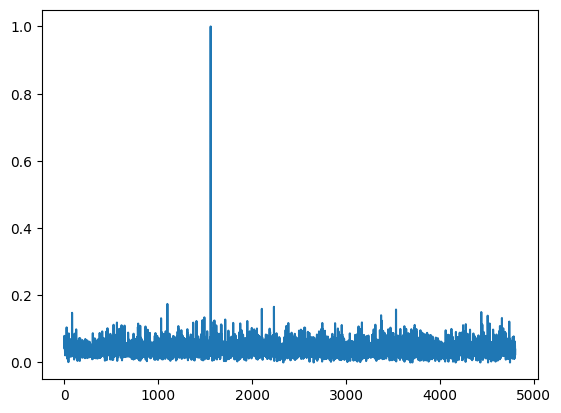

In [240]:
query.toarray()
scores = cosine_similarity(query, X)
scores = scores.flatten()
plt.plot(scores);

In [241]:
best_movies = [df['title'][idx] for idx, scor in enumerate(scores) if 1 > scor > 0.13]
best_movies

['The Lovers',
 "My Best Friend's Wedding",
 'Love in the Time of Cholera',
 'The Reader',
 'The Last Song',
 'Little Boy',
 'Veer-Zaara',
 'Iris',
 'Bambi',
 'Love Letters',
 'The Big Parade']

In [242]:
def recommendation(title, n):
    idx = movie2idx[title]
    query = X[idx]
    query.toarray()
    scores = cosine_similarity(query, X)
    scores = scores.flatten()
    plt.plot(scores);
    recommended_idx = (-scores).argsort()[1:n+1]
    return df['title'].iloc[recommended_idx]

1531                       Moonraker
373                  Mission to Mars
0                             Avatar
95                      Interstellar
1709    Space Pirate Captain Harlock
149                       Armageddon
333                    Transcendence
1951                      Space Dogs
661       Zathura: A Space Adventure
643                    Space Cowboys
Name: title, dtype: object

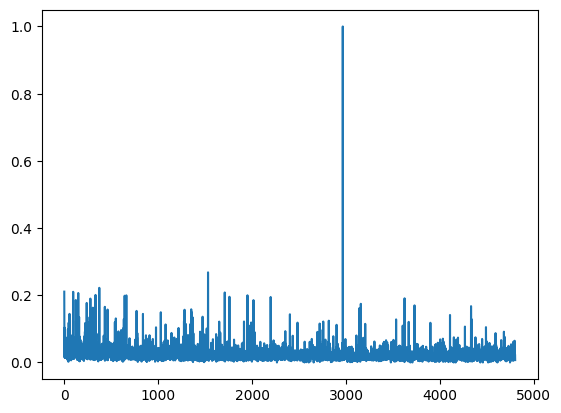

In [243]:
recommendation("2001: A Space Odyssey", 10)